In [ ]:
!pip install skl2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 3.20.2 which is incompatible.


In [ ]:
# Import libraries
import os
import io
import csv
import cv2
import zipfile
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import pickle
import joblib

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
directory_path = '/content/drive/MyDrive/DatasetAugmen'
csv_path = '/content/drive/MyDrive/datacabai2.csv'

Mounted at /content/drive


In [ ]:
# Load CSV data
data_csv = pd.read_csv(csv_path)

In [ ]:
# Load images and labels
label_list = [ 'Segar', 'Kering']
data = []
labels = []

for label in label_list:
    folder_path = os.path.join(directory_path, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        data.append(image)
        labels.append(label)

data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [ ]:

# Display label encoding
labels_df = pd.DataFrame({'Original Labels': labels, 'Encoded Labels': encoded_labels})
print(labels_df)

     Original Labels  Encoded Labels
0              Segar               1
1              Segar               1
2              Segar               1
3              Segar               1
4              Segar               1
...              ...             ...
1103          Kering               0
1104          Kering               0
1105          Kering               0
1106          Kering               0
1107          Kering               0

[1108 rows x 2 columns]


In [ ]:
# Load MobileNetV2 model
model_path = '/content/drive/MyDrive/Model/mobilenet2_model.h5'
loaded_model = load_model(model_path)

In [ ]:
# Extract features using MobileNetV2
features = loaded_model.predict(data)
flattened_features = features.reshape((features.shape[0], -1))

# Combine features from MobileNetV2 with CSV data
csv_features = data_csv[['berat_cabai', 'kadar_air']].values
combined_features = np.concatenate((flattened_features, csv_features), axis=1)

35/35 [==============================] - 39s 1s/step


In [ ]:
# Display combined features
columns = [f'feature_{i}' for i in range(flattened_features.shape[1])] + ['berat_cabai', 'kadar_air']
combined_features_df = pd.DataFrame(combined_features, columns=columns)
print("Combined Features Data:")
print(combined_features_df.head())

Combined Features Data:
   feature_0  feature_1  feature_2  berat_cabai  kadar_air
0   0.004566   0.037811   0.957623         2.31      26.41
1   0.087961   0.639989   0.272050         2.01      24.87
2   0.126245   0.144006   0.729749         2.66      22.18
3   0.148976   0.547365   0.303659         1.98      25.76
4   0.135233   0.517087   0.347680         2.31      26.41


In [ ]:
# Train RandomForest model
X_train, X_test, y_train, y_test = train_test_split(combined_features, encoded_labels, test_size=0.2, random_state=42)
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Predict and evaluate
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       106
           1       0.99      1.00      1.00       116

    accuracy                           1.00       222
   macro avg       1.00      1.00      1.00       222
weighted avg       1.00      1.00      1.00       222

Accuracy: 0.9954954954954955


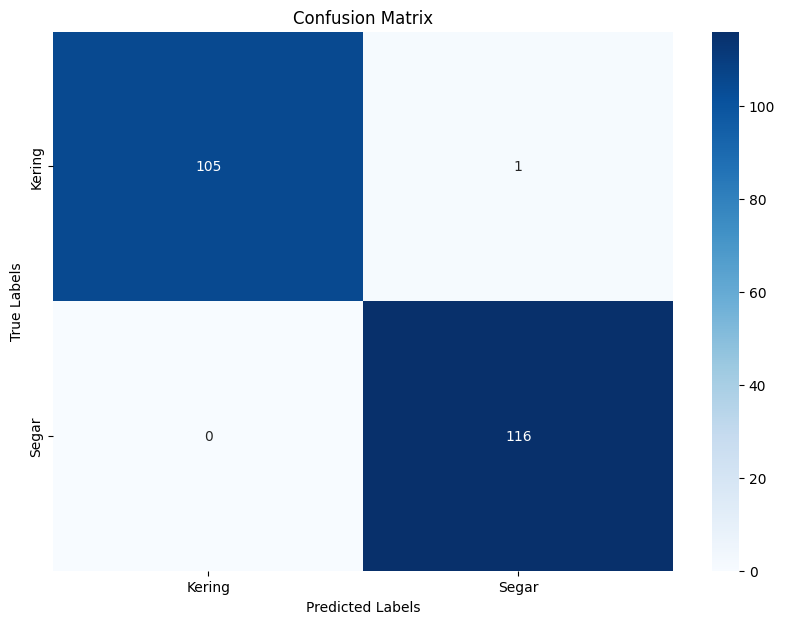

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save RandomForest model in ONNX format
initial_type = [('float_input', FloatTensorType([None, combined_features.shape[1]]))]
onnx_model = convert_sklearn(random_forest, initial_types=initial_type)
onnx_model_path = '/content/drive/MyDrive/Model/randomforest2_model.onnx'
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"Model Random Forest disimpan dalam format ONNX di: {onnx_model_path}")


Model Random Forest disimpan dalam format ONNX di: /content/drive/MyDrive/Model/randomforest2_model.onnx


In [ ]:
# Save RandomForest model in .pkl format
model_path_pkl = '/content/drive/MyDrive/Model/random_forest_model.pkl'
with open(model_path_pkl, 'wb') as f:
    pickle.dump(random_forest, f)


In [ ]:
# Save RandomForest model in joblib format
model_path_joblib = '/content/drive/MyDrive/Model/random_forest_model.joblib'
joblib.dump(random_forest, model_path_joblib)

['/content/drive/MyDrive/Model/random_forest_model.joblib']

In [ ]:
# Train regressors for 'berat_cabai' and 'kadar_air'
X_train_berat, X_test_berat, y_train_berat, y_test_berat = train_test_split(flattened_features, data_csv['berat_cabai'], test_size=0.2, random_state=42)
regressor_berat_cabai = RandomForestRegressor()
regressor_berat_cabai.fit(X_train_berat, y_train_berat)

X_train_air, X_test_air, y_train_air, y_test_air = train_test_split(flattened_features, data_csv['kadar_air'], test_size=0.2, random_state=42)
regressor_kadar_air = RandomForestRegressor()
regressor_kadar_air.fit(X_train_air, y_train_air)

RandomForestRegressor()

In [ ]:
# Save regressor models in ONNX format
initial_type = [('float_input', FloatTensorType([None, X_train_berat.shape[1]]))]
onnx_model_berat = convert_sklearn(regressor_berat_cabai, initial_types=initial_type)
onnx_model_berat_path = '/content/drive/MyDrive/Model/regressor_berat_cabai_model.onnx'
with open(onnx_model_berat_path, "wb") as f:
    f.write(onnx_model_berat.SerializeToString())
print(f"Model regressor_berat_cabai disimpan dalam format ONNX di: {onnx_model_berat_path}")


Model regressor_berat_cabai disimpan dalam format ONNX di: /content/drive/MyDrive/Model/regressor_berat_cabai_model.onnx


In [ ]:
onnx_model_air = convert_sklearn(regressor_kadar_air, initial_types=initial_type)
onnx_model_air_path = '/content/drive/MyDrive/Model/regressor_kadar_air_model.onnx'
with open(onnx_model_air_path, "wb") as f:
    f.write(onnx_model_air.SerializeToString())
print(f"Model regressor_kadar_air disimpan dalam format ONNX di: {onnx_model_air_path}")

# Convert and save MobileNetV2 model to TFLite

Model regressor_kadar_air disimpan dalam format ONNX di: /content/drive/MyDrive/Model/regressor_kadar_air_model.onnx


In [ ]:
# Convert and save MobileNetV2 model to TFLite
def convert_to_tflite(model, tflite_model_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

tflite_model_path = '/content/drive/MyDrive/Model/mobilenet2_model.tflite'
convert_to_tflite(loaded_model, tflite_model_path)
print(f"Model MobileNetV2 disimpan dalam format TFLite di: {tflite_model_path}")

Model MobileNetV2 disimpan dalam format TFLite di: /content/drive/MyDrive/Model/mobilenet2_model.tflite


In [ ]:
# Load and process image
def load_and_process_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

1/1 [==============================] - 0s 100ms/step
Prediction: Segar
Predicted Berat Cabai: 2.5176000000000016
Predicted Kadar Air: 31.345699999999983


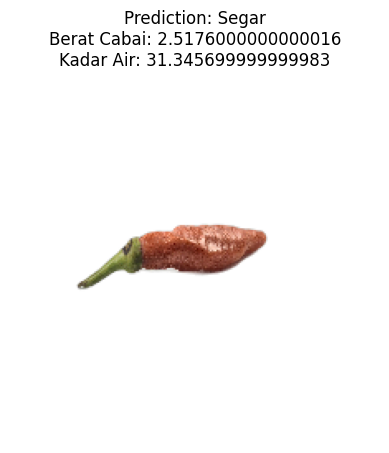

In [ ]:
# Load and process image
def load_and_process_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Predict additional attributes
def predict_additional_attributes(features, regressor_berat_cabai, regressor_kadar_air):
    kadar_air = regressor_kadar_air.predict(features)
    berat_cabai = regressor_berat_cabai.predict(features)
    return np.column_stack((berat_cabai, kadar_air))

# Predict image category with additional attributes
def predict_image_with_automatic_attributes(image_path, model, random_forest, regressor_berat_cabai, regressor_kadar_air):
    processed_image = load_and_process_image(image_path)
    features = model.predict(processed_image)
    flattened_features = features.reshape((features.shape[0], -1))

    # Predict additional attributes (berat cabai and kadar air)
    additional_features = predict_additional_attributes(flattened_features, regressor_berat_cabai, regressor_kadar_air)

    # Combine image features with predicted additional attributes
    combined_features = np.concatenate((flattened_features, additional_features), axis=1)

    # Predict using Random Forest model
    prediction = random_forest.predict(combined_features)
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    berat_cabai, kadar_air = additional_features[0]

    return predicted_label, berat_cabai, kadar_air

# Example usage of prediction function
new_image_path = '/content/drive/My Drive/DatasetAugmen/Segar/Cabai 18b_0_2.jpg'  # Path to your new image
predicted_label, berat_cabai, kadar_air = predict_image_with_automatic_attributes(new_image_path, loaded_model, random_forest, regressor_berat_cabai, regressor_kadar_air)
print(f"Prediction: {predicted_label}")
print(f"Predicted Berat Cabai: {berat_cabai}")
print(f"Predicted Kadar Air: {kadar_air}")

# Load and display the image with prediction
img = load_img(new_image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.title(f'Prediction: {predicted_label}\nBerat Cabai: {berat_cabai}\nKadar Air: {kadar_air}')
plt.show()

1/1 [==============================] - 0s 68ms/step
Prediction: Segar
Predicted Berat Cabai: 3.0490000000000004
Predicted Kadar Air: 33.47850000000005


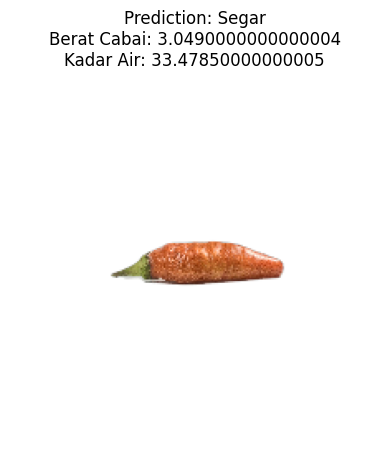

In [ ]:
# Load and process image
def load_and_process_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Predict additional attributes
def predict_additional_attributes(features, regressor_berat_cabai, regressor_kadar_air):
    kadar_air = regressor_kadar_air.predict(features)
    berat_cabai = regressor_berat_cabai.predict(features)
    return np.column_stack((berat_cabai, kadar_air))

# Predict image category with additional attributes
def predict_image_with_automatic_attributes(image_path, model, random_forest, regressor_berat_cabai, regressor_kadar_air):
    processed_image = load_and_process_image(image_path)
    features = model.predict(processed_image)
    flattened_features = features.reshape((features.shape[0], -1))

    # Predict additional attributes (berat cabai and kadar air)
    additional_features = predict_additional_attributes(flattened_features, regressor_berat_cabai, regressor_kadar_air)

    # Combine image features with predicted additional attributes
    combined_features = np.concatenate((flattened_features, additional_features), axis=1)

    # Predict using Random Forest model
    prediction = random_forest.predict(combined_features)
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    berat_cabai, kadar_air = additional_features[0]

    return predicted_label, berat_cabai, kadar_air

# Example usage of prediction function
new_image_path = '/content/drive/My Drive/DatasetAugmen/Segar/Cabai 3a_2_2.jpg'  # Path to your new image
predicted_label, berat_cabai, kadar_air = predict_image_with_automatic_attributes(new_image_path, loaded_model, random_forest, regressor_berat_cabai, regressor_kadar_air)
print(f"Prediction: {predicted_label}")
print(f"Predicted Berat Cabai: {berat_cabai}")
print(f"Predicted Kadar Air: {kadar_air}")

# Load and display the image with prediction
img = load_img(new_image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.title(f'Prediction: {predicted_label}\nBerat Cabai: {berat_cabai}\nKadar Air: {kadar_air}')
plt.show()

1/1 [==============================] - 0s 108ms/step
Prediction: Segar
Predicted Kadar Air: 33.28040000000001


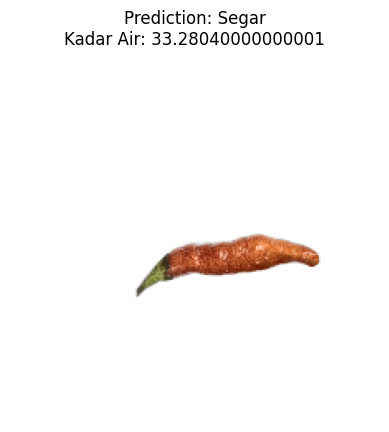

In [ ]:
# Load and process image
def load_and_process_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Predict additional attributes
def predict_additional_attributes(features, regressor_berat_cabai, regressor_kadar_air):
    kadar_air = regressor_kadar_air.predict(features)
    berat_cabai = regressor_berat_cabai.predict(features)
    return np.column_stack((berat_cabai, kadar_air))

# Predict image category with additional attributes
def predict_image_with_automatic_attributes(image_path, model, random_forest, regressor_berat_cabai, regressor_kadar_air):
    processed_image = load_and_process_image(image_path)
    features = model.predict(processed_image)
    flattened_features = features.reshape((features.shape[0], -1))

    # Predict additional attributes (berat cabai and kadar air)
    additional_features = predict_additional_attributes(flattened_features, regressor_berat_cabai, regressor_kadar_air)

    # Combine image features with predicted additional attributes
    combined_features = np.concatenate((flattened_features, additional_features), axis=1)

    # Predict using Random Forest model
    prediction = random_forest.predict(combined_features)
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    berat_cabai, kadar_air = additional_features[0]

    return predicted_label, berat_cabai, kadar_air

# Example usage of prediction function
new_image_path = '/content/drive/My Drive/DatasetAugmen/Sedang/Cabai 2b_4_2.jpg'  # Path to your new image
predicted_label, berat_cabai, kadar_air = predict_image_with_automatic_attributes(new_image_path, loaded_model, random_forest, regressor_berat_cabai, regressor_kadar_air)
print(f"Prediction: {predicted_label}")
print(f"Predicted Kadar Air: {kadar_air}")

# Load and display the image with prediction
img = load_img(new_image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.title(f'Prediction: {predicted_label}\nKadar Air: {kadar_air}')
plt.show()

1/1 [==============================] - 0s 86ms/step
Prediction: Kering
Predicted Kadar Air: 8.184700000000014


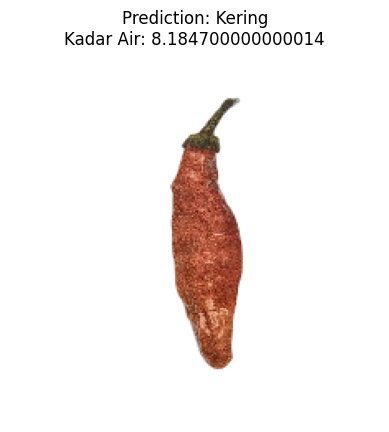

In [ ]:
# Load and process image
def load_and_process_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Predict additional attributes
def predict_additional_attributes(features, regressor_berat_cabai, regressor_kadar_air):
    kadar_air = regressor_kadar_air.predict(features)
    berat_cabai = regressor_berat_cabai.predict(features)
    return np.column_stack((berat_cabai, kadar_air))

# Predict image category with additional attributes
def predict_image_with_automatic_attributes(image_path, model, random_forest, regressor_berat_cabai, regressor_kadar_air):
    processed_image = load_and_process_image(image_path)
    features = model.predict(processed_image)
    flattened_features = features.reshape((features.shape[0], -1))

    # Predict additional attributes (berat cabai and kadar air)
    additional_features = predict_additional_attributes(flattened_features, regressor_berat_cabai, regressor_kadar_air)

    # Combine image features with predicted additional attributes
    combined_features = np.concatenate((flattened_features, additional_features), axis=1)

    # Predict using Random Forest model
    prediction = random_forest.predict(combined_features)
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    berat_cabai, kadar_air = additional_features[0]

    return predicted_label, berat_cabai, kadar_air

# Example usage of prediction function
new_image_path = '/content/drive/My Drive/DatasetAugmen/Kering/Cabai 2b_10_2.jpg'  # Path to your new image
predicted_label, berat_cabai, kadar_air = predict_image_with_automatic_attributes(new_image_path, loaded_model, random_forest, regressor_berat_cabai, regressor_kadar_air)
print(f"Prediction: {predicted_label}")
print(f"Predicted Kadar Air: {kadar_air}")

# Load and display the image with prediction
img = load_img(new_image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.title(f'Prediction: {predicted_label}\nKadar Air: {kadar_air}')
plt.show()